In [1]:
## explainer notebook demographic part

In [2]:
import os
import json
from functools import partial

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex
import matplotlib.patches as mpatches

import plotly.express as px
import plotly.io as pio

from bokeh.io import output_notebook, show
from bokeh.layouts import column, row                  
from bokeh.models import (ColumnDataSource, CheckboxGroup, CustomJS)
from bokeh.plotting import figure
from bokeh.palettes import Category10, Category20
from bokeh.transform import dodge

from shapely.geometry import shape
import folium
from folium import FeatureGroup
from folium.plugins import TimestampedGeoJson

import ipywidgets as widgets
from IPython.display import display, clear_output

# Pandas settings
pd.set_option('future.no_silent_downcasting', True)

In [3]:
hex_colors = ['#FDFAE1', '#241B5F', '#FFB400', '#4A4DE9', '#FF5A00', '#FF6273', '#FF95A1', '#F3DCC6'] 

expanded_colors = ['#241B5F', '#6A66B2','#FFB400', '#FFE299','#4A4DE9', '#A7AAFF', '#FF5A00', '#FF9D5C', '#FF6273', '#FFAAB2', '#FF95A1', '#FFD4DA', '#F3DCC6', '#EBD2BB']

wing_colors = {'left': '#d52729', 'right': '#00739b'}

def lighten_hex(hexcode: str, factor: float) -> str:
    """
    Return `hexcode` lightened toward white.

    * `factor = 0.0` → original colour
    * `factor = 1.0` → white
    """
    hexcode = hexcode.lstrip('#')
    r, g, b = (int(hexcode[i:i+2], 16) for i in (0, 2, 4))
    r = int(r + (255 - r) * factor)
    g = int(g + (255 - g) * factor)
    b = int(b + (255 - b) * factor)
    return f"#{r:02X}{g:02X}{b:02X}"

def make_palette(n_groups: int) -> list[str]:
    palette   = []
    base_len  = len(hex_colors)

    i = 0
    while len(palette) < n_groups:
        base_idx   = i // 2 % base_len          # 0‑7, 0‑7, 0‑7, …
        cycle      = i // (2 * base_len)        # 0 for first 16 colours,
                                                # 1 for next 16, …
        is_light   = i % 2 == 1                 # odd positions → lighter
        base_col   = hex_colors[base_idx]

        factor = 0.45 if is_light else 0.0
        factor += 0.25 * cycle                 # make later rings lighter
        factor = min(factor, 0.9)              # never reach pure white

        palette.append(lighten_hex(base_col, factor))
        i += 1

    return palette[:n_groups]

## Basic stats

#### Data loading

In [4]:
# Load the data
df_geo = pd.read_csv('Data/processed/Geografi.csv', sep=';', decimal=',', na_values='-')
df_geo.columns = df_geo.columns.str.replace(' ', '', regex=True)

# Filter the data to only keep Copenhagen Constituencies 
df_geo_cph = df_geo.query("Storkredsnavn=='Københavns Storkreds'").drop_duplicates()
df_geo_cph['KredsNr'] = df_geo_cph['KredsNr'].astype(int)

# Keep only the necessary columns
df_geo_cph = df_geo_cph[['KredsNr', 'Kredsnavn','KommuneNr','Kommunenavn']]

# Replace Utterslev with Bispebjerg
df_geo_cph['Kredsnavn'] = df_geo_cph['Kredsnavn'].replace({'6. Utterslev':'6. Bispebjerg'})

# Drop duplicates
df_geo_cph = df_geo_cph.drop_duplicates(subset=['KredsNr', 'Kredsnavn','KommuneNr','Kommunenavn'])

print("Geography data shape:", df_geo_cph.shape)

Geography data shape: (13, 4)


In [5]:
# Split the 'Kredsnavn' column into two parts: ID and Name
constituency_split = df_geo_cph['Kredsnavn'].drop_duplicates().str.split('.', n=1, expand=True)
constituency_split.columns = ['ConstituencyID', 'ConstituencyName']

# Convert ID column to integers and strip whitespace from the names
constituency_split['ConstituencyID'] = constituency_split['ConstituencyID'].astype(int)
constituency_split['ConstituencyName'] = constituency_split['ConstituencyName'].str.strip()

# Create a mapping from ID to Name
constituency_id_to_name = dict(zip(constituency_split['ConstituencyID'], constituency_split['ConstituencyName']))

# Create a reverse mapping from Name to ID
constituency_name_to_id = {name: id_ for id_, name in constituency_id_to_name.items()}

In [6]:
# Load the population data
df_population = pd.read_csv("Data/processed/Befolkning.csv", sep=';', low_memory=False, decimal=',', na_values='-')
df_population.columns = df_population.columns.str.replace(' ', '', regex=True)

# Filter the population data to only keep the relevant constituencies
df_population_cph = df_population[df_population['KredsNr'].isin([str(k) for k in constituency_id_to_name.keys()])]
df_population_cph.loc[:, 'KredsNr'] = df_population_cph['KredsNr'].astype(int)

print(f"Population data shape: {df_population_cph.shape}")

Population data shape: (12, 11374)


In [7]:
# Drop columns with all NaN values
df_population_cph = df_population_cph.dropna(axis=1, how='all')
print(f"Population data shape after dropping empty columns: {df_population_cph.shape}")

Population data shape after dropping empty columns: (12, 5824)


In [8]:
# Replace NaN values with 0 & convert to numeric
df_population_cph.fillna(0, inplace=True) 
df_population_cph = df_population_cph.apply(pd.to_numeric, errors='coerce')

#### Data Cleaning

In [9]:
# Extract the socioeconomic columns
socioeconomic_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Socio-økonomiskstatusogbrancherfordeltpåafstemningsområder" in col]

# Melt to long format
df_socio_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=socioeconomic_cols,
    var_name='RawColumn',
    value_name='Count')

# Extract Year, Employment Group, and Industry
df_socio_long[['Year', 'EmploymentGroup', 'Industry']] = df_socio_long['RawColumn'].str.extract(
    r'FV(\d{4})-Socio-økonomiskstatusogbrancherfordeltpåafstemningsområder_\d+\.(.+?)_(.+)')

# Clean up columns
df_socio_long = df_socio_long.drop(columns=['RawColumn'])
df_socio_long = df_socio_long[['Gruppe', 'KredsNr', 'Year', 'EmploymentGroup', 'Industry', 'Count']]

print(f"Socioeconomic data shape: {df_socio_long.shape}")

Socioeconomic data shape: (5760, 6)


In [10]:
industry_mapping = {
    '01.Landbrugskovbrugogfiskeri': 'Agriculture, Forestry and Fishing',
    '02.Industriråstofindvindingogforsyningsvirksomhed': 'Manufacturing, Mining and Utilities',
    '03.Byggeoganlæg': 'Construction',
    '04.Handelogtransportmv.': 'Trade and Transport',
    '05.Informationogkommunikation': 'Information and Communication',
    '06.Finansieringogforsikring': 'Finance and Insurance',
    '07.Ejendomshandelogudlejning': 'Real Estate',
    '08.Erhvervsservice': 'Business Services',
    '09.Offentligadministrationundervisningogsundhed': 'Public Administration, Education and Health',
    '10.Kulturfritidogandenservice': 'Culture, Leisure and Other Services',
    '11.Ikkebeskæftiget': 'Not Employed',
    '12.Uoplystaktivitet': 'Unknown Activity',
    
    # Also map to englisgh names
    'Landbrugskovbrugogfiskeri': 'Agriculture, Forestry and Fishing',
    'Industriråstofindvindingogforsyningsvirksomhed': 'Manufacturing, Mining and Utilities',
    'Byggeoganlæg': 'Construction',
    'Handelogtransportmv.': 'Trade and Transport',
    'Informationogkommunikation': 'Information and Communication',
    'Finansieringogforsikring': 'Finance and Insurance',
    'Ejendomshandelogudlejning': 'Real Estate',
    'Erhvervsservice': 'Business Services',
    'Offentligadministrationundervisningogsundhed': 'Public Administration, Education and Health',
    'Kulturfritidogandenservice': 'Culture, Leisure and Other Services',
    'Ikkebeskæftiget': 'Not Employed',
    'Uoplystaktivitet': 'Unknown Activity'
}

# should be good mapping now
status_mapping = { 
    'Selvstændigogmedhj.': 'Self-employed and Assistants',
    'Topledere': 'Executives',
    'Lønmodtagerepåhøjtniveau': 'Employees at High Skill Level',
    'Lønmodtagerepåmellemniveau': 'Employees at Medium Skill Level',
    'Lønmodtagerepågrundniveau': 'Employees at Basic Skill Level',
    'Øvrigelønmodtagere': 'Employees at Basic Skill Level',
    'Arbejdsløse': 'Unemployed',
    'Øvrige(offentligtforsørgede)': 'Publicly Supported',
    'Uddannelsessøgende': 'Education Seekers',
    'Folke-ogtjenestemandspension': 'Pensioners',
    'Efterløn': 'Pensioners',
    'Børn': 'Children'
}

df_socio_long['Industry'] = df_socio_long['Industry'].map(industry_mapping)
df_socio_long['EmploymentGroup'] = df_socio_long['EmploymentGroup'].map(status_mapping)

Source for mapping the socio status: https://samfundsfag.dk/begreber/sociologi/social-differentiering-kulturelle-moenstre/sociooekonomisk-klassifikation/?fbclid=IwZXh0bgNhZW0CMTEAAR5Hq-9PMJjMZQGEe_z1qB_EzswXhnksNY3ZPrIaAsWmncSzFe0yM3WSZbAN-w_aem_HqaLamHZsURXMZmeIWAczg

In [11]:
# Extract the support columns
support_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Personerefterforsørgelsestype" in col]

# Melt the DataFrame
df_support_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=support_cols,
    var_name='RawColumn',
    value_name='Count')

# Extract Year and SupportType
df_support_long[['Year', 'SupportType']] = df_support_long['RawColumn'].str.extract(
    r'FV(\d{4})-Personerefterforsørgelsestype_\d+\.(.+)')

# Clean up
df_support_long = df_support_long.drop(columns='RawColumn')
df_support_long = df_support_long[['Gruppe', 'KredsNr', 'Year', 'SupportType', 'Count']]

print(f"Support data shape: {df_support_long.shape}")

Support data shape: (576, 5)


In [12]:
support_mapping = {
    'Arbejdsløshedsdagpenge': 'Unemployment Benefits',
    'LedighedsydelseogFleksjob': 'Unemployment Benefits',
    'Aktivering': 'Unemployment Benefits',
    'Sygedagpenge': 'Health / Disability Support',
    'Kontanthjælp': 'Social Assistance (Cash Benefits)',
    'Revalidering': 'Health / Disability Support',
    'Barselsdagpenge': 'Parental Leave Benefits',
    'Førtidspension': 'Health / Disability Support',
    'Efterløn': 'Pension Support',
    'Folkepension': 'Pension Support',
    'Modtagerikkeydelser': 'No Received Benefits',
    'Antalpersonerialt': 'Total Number of Persons'
}
df_support_long['SupportType'] = df_support_long['SupportType'].map(support_mapping)

Inspiration from the categories that DST seperate their kontantydelser : Source

https://www.dst.dk/da/Statistik/emner/oekonomi/offentlig-oekonomi/sociale-udgifter

Also from: "Offentligt forsøgede" what the category cover: source: https://www.dst.dk/da/Statistik/emner/sociale-forhold/offentligt-forsoergede Both SU (students), cash benefits, (normally parental leave, but this is noted in another category), (efterløn, førtidspension, also noted in another category)

In [13]:
# Filter relevant income columns
income_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Husstandsindkomsterfordeltpåafstemningsområder" in col]

# Melt
df_income_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=income_cols,
    var_name='RawColumn',
    value_name='Value')

# Extract Year + IncomeMetric
df_income_long[['Year', 'IncomeMetric']] = df_income_long['RawColumn'].str.extract(
    r'FV(\d{4})-Husstandsindkomsterfordeltpåafstemningsområder_(.+)')

# Clean up
df_income_long = df_income_long.drop(columns='RawColumn')
df_income_long = df_income_long[['Gruppe', 'KredsNr', 'Year', 'IncomeMetric', 'Value']]

print(f"Income data shape: {df_income_long.shape}")

Income data shape: (816, 5)


In [14]:
hoursing_size_columns = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "boligstørrelse" in col]

# Melt to long format
df_house_size_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=hoursing_size_columns,
    var_name='RawColumn',
    value_name='Count')

# Extract year, aggregate level, and size category
df_house_size_long[['Year', 'AggregateLevel', 'HouseSize']] = df_house_size_long['RawColumn'].str.extract(
    r'FV(\d{4})-Boligerogpersonerefterboligstørrelse_\d+\.(?:Antal)?(boliger|personer)_(.+)')

df_house_size_long['AggregateLevel'] = df_house_size_long['AggregateLevel'].map({'boliger': 'Units', 'personer': 'Residents'})

# Reorder columns
df_house_size_long = df_house_size_long[['Gruppe', 'KredsNr', 'Year', 'AggregateLevel', 'HouseSize', 'Count']]

# Drop columns with NaN values
df_house_size_long = df_house_size_long.dropna(subset=['Year', 'AggregateLevel', 'HouseSize'])

print(f"House size data shape: {df_house_size_long.shape}")

House size data shape: (936, 6)


#### Analysis

##### Support

In [15]:
#### Support analysis

# Group and aggregate
df_total_pers = df_support_long.query("SupportType=='Total Number of Persons'").groupby('Year')['Count'].sum().reset_index()
df_total_pers = df_total_pers.rename(columns={'Count': 'TotalPersons'})

df_support_count = df_support_long.query("SupportType!='Total Number of Persons'").groupby(['Year', 'SupportType'])['Count'].sum().reset_index()

df_support_ratio = pd.merge(df_support_count, df_total_pers, on='Year')
df_support_ratio['SupportRatio'] = df_support_ratio['Count'] / df_support_ratio['TotalPersons']

# Exclude "No Received Benefits"
df_support_filtered = df_support_ratio[df_support_ratio['SupportType'] != 'No Received Benefits']
df_no_benefits = df_support_ratio[df_support_ratio['SupportType'] == 'No Received Benefits']
print("'No Benefits' ratio by year:")
print(df_no_benefits[['Year', 'SupportRatio']])


'No Benefits' ratio by year:
    Year  SupportRatio
1   2011      0.641793
7   2015      0.660979
13  2019      0.687349
19  2022      0.687349


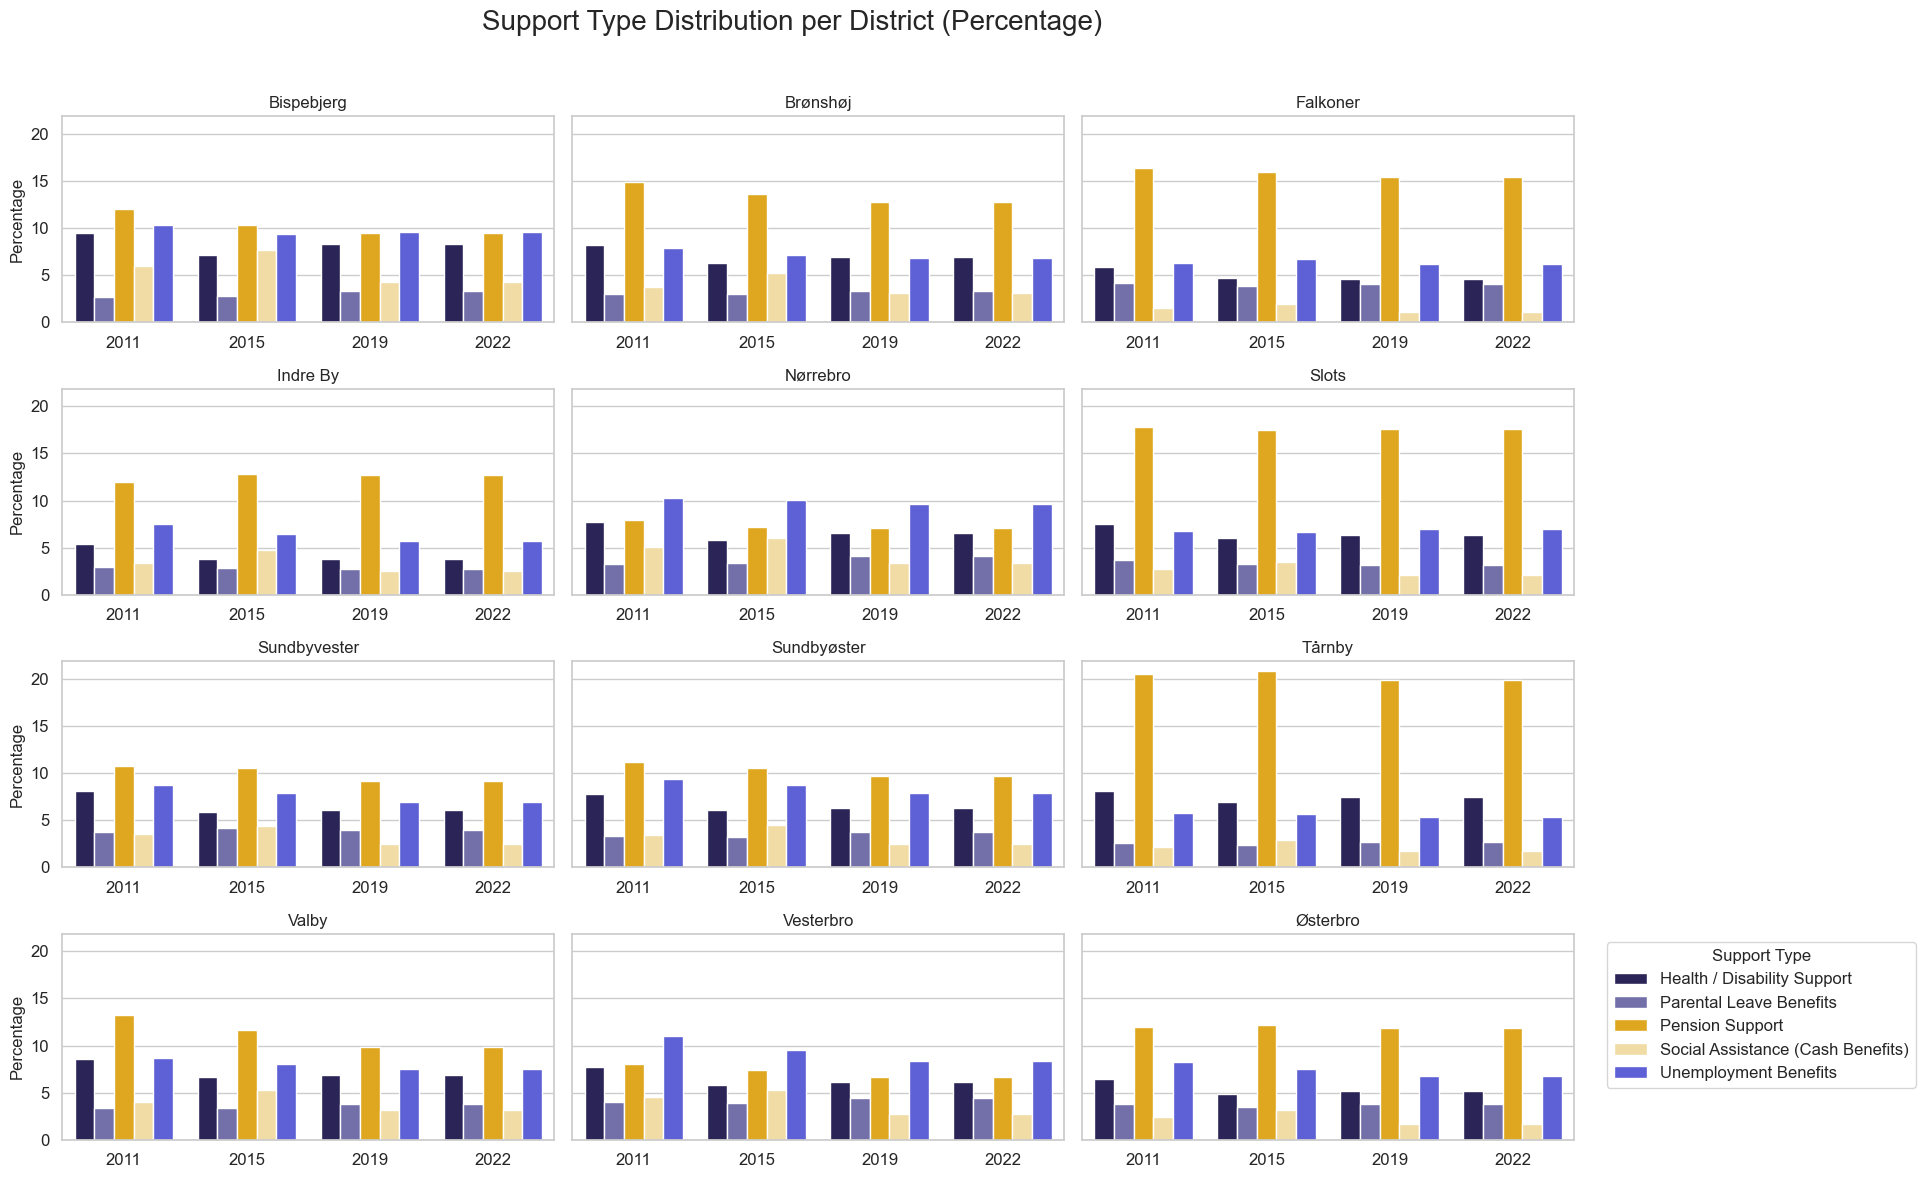

In [16]:
# Toggle for excluding 'No Received Benefits' from *plotting* (but still include in totals)
exclude_no_benefits = True

# Filter out "Total Number of Persons"
df_support_filtered = df_support_long[df_support_long['SupportType'] != 'Total Number of Persons'].copy()

# Map district names
df_support_filtered['District'] = df_support_filtered['KredsNr'].map(constituency_id_to_name)

# Aggregate counts per Year, District, SupportType
df_support_grouped = df_support_filtered.groupby(['Year', 'SupportType', 'District'], observed=True)['Count'].sum().reset_index()

# Compute totals including all support types (including 'No Received Benefits')
df_totals = df_support_grouped.groupby(['Year', 'District'], observed=True)['Count'].sum().reset_index(name='Total')

# Merge totals back and compute percentage
df_support_grouped = df_support_grouped.merge(df_totals, on=['Year', 'District'])
df_support_grouped['Percentage'] = (df_support_grouped['Count'] / df_support_grouped['Total']) * 100

# Optionally exclude 'No Received Benefits' *from plotting only*
if exclude_no_benefits:
    df_support_grouped = df_support_grouped[df_support_grouped['SupportType'] != 'No Received Benefits']

# Define support types and color palette
support_types = df_support_grouped['SupportType'].unique()
support_palette = dict(zip(support_types, expanded_colors[:len(support_types)]))

# Plot setup
sns.set_theme(style="whitegrid", font="Arial")

districts = df_support_grouped['District'].unique()
cols = 3
rows = 4
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3), sharey=True)
axes = axes.flatten()

# Plot per district (using percentages)
for idx, district in enumerate(districts):
    ax = axes[idx]
    df_district = df_support_grouped[df_support_grouped['District'] == district]
    sns.barplot(
        data=df_district,
        x='Year',
        y='Percentage',
        hue='SupportType',
        order=sorted(df_district['Year'].unique()),
        hue_order=support_types,
        errorbar=None,
        palette=support_palette,
        ax=ax
    )
    ax.set_title(district, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage', fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend_.remove()

# Remove empty subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Main title and legend
fig.suptitle('Support Type Distribution per District (Percentage)', fontsize=20, fontname='Arial')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.legend(title='Support Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12)
plt.show()


For explainer notebook basic stats part.^^

Unemployment Benefits are slightly higher for Nørrebro and Vesterbro compared percentage wise to other districts.

Pension support for the districts Falkoner, Slots, Tårnby (Indre & Brønshøj) indicates just there are more elder people.

The 'No Received Benefits' are used to normalize the counts for each year.

The years 2019 and 2022 are the same.

##### Income

In [17]:
df_income_long['IncomeMetric'].unique()

array(['100.000-149.999kr', '150.000-199.999kr.', '200.000-299.999kr.',
       '300.000-399.999kr.', '400.000-499.999kr.',
       '50%-percentilforhusstandsindkomst', '500.000-749.999kr.',
       '750.000kr.-', '80%-percentilforhusstandsindkomst',
       'Antalhusstandeialt', 'Bruttoindkomstforde20%dertjenermest',
       'Bruttoindkomstforde50%dertjenermest', 'Husstandenesformuesum',
       'Husstandenesindkomstbruttosum',
       'Sumafformueforde20%dertjenermest',
       'Sumafformueforde50%dertjenermest', 'Under100.000kr.'],
      dtype=object)

In [25]:
# Define income brackets
income_brackets = [
    'Under100.000kr.',
    '100.000-149.999kr',
    '150.000-199.999kr.',
    '200.000-299.999kr.',
    '300.000-399.999kr.',
    '400.000-499.999kr.',
    '500.000-749.999kr.',
    '750.000kr.+'
]

# Aggregate household counts and income bracket counts per year
df_compare = (
    df_income_long
    .assign(Category=lambda df: df['IncomeMetric'].apply(lambda x: 'Households' if x == 'Antalhusstandeialt' 
                                                         else 'Income Bracket' if x in income_brackets 
                                                         else 'Other'))
    .query("Category != 'Other'")  # Keep only relevant rows
    .groupby(['Year', 'Category'], observed=True)['Value']
    .sum()
    .unstack()
    .reset_index()
)

# Calculate difference
df_compare['Difference'] = df_compare['Households'] - df_compare['Income Bracket']

# Show the result
df_compare


Category,Year,Households,Income Bracket,Difference
0,2011,353908.0,309616.0,44292.0
1,2015,362822.0,292360.0,70462.0
2,2019,388705.0,280459.0,108246.0
3,2022,388705.0,280459.0,108246.0


Number households seems small... TODO https://www.kk.dk/om-kommunen/fakta-og-statistik/noegletalsanalyser

Population count: Kommuner: Tårnby + København + Frederiksberg:
44107+669362+106169 = 819638 people

Average people in a household: All of Denmark 5998205 population / 1857302 households (march 2025) = 3.2295 people pr household

Household source: https://www.dst.dk/en/Statistik/emner/borgere/husstande-familier-og-boern/husstande-og-familier

Population source: https://www.dst.dk/en/Statistik/emner/borgere/befolkning/befolkningstal 

819638 / 3.2295 = 253797.18 households in copenhagen.

This is less than shown 388705.0 households. But an Urban area like Copenhagen could have smaller average household size than other areas. If 2 people pr household the population fits.

Could just find a source for copenhagen households...

In [24]:
# Filter income brackets
df_income_filtered = df_income_long[df_income_long['IncomeMetric'].isin(income_brackets)].copy()

# Apply income order
df_income_filtered['IncomeMetric'] = pd.Categorical(df_income_filtered['IncomeMetric'], categories=income_brackets, ordered=True)

# Aggregate by Year and Income Bracket
df_income_grouped = df_income_filtered.groupby(['Year', 'IncomeMetric'], observed=True)['Value'].sum().reset_index()

# Normalize counts to percentages per year
df_income_grouped['Percentage'] = df_income_grouped.groupby('Year')['Value'].transform(lambda x: 100 * x / x.sum())

# Apply colors (reuse your palette)
palette = dict(zip(income_brackets, expanded_colors[:len(income_brackets)]))

# Plot percentages (side-by-side)
fig = px.bar(
    df_income_grouped,
    x='Year',
    y='Percentage',
    color='IncomeMetric',
    barmode='group',
    title='Income Distribution Over Time (Percentages, Side-by-Side)',
    category_orders={'IncomeMetric': income_brackets},
    color_discrete_map=palette
)

# Sort years
fig.update_layout(
    xaxis=dict(
        categoryorder='array',
        categoryarray=sorted(df_income_grouped['Year'].unique())
    )
)

fig.show()


INFORMATIVE: Very interesting that the percentage of people earning 750.000kr+ increases!

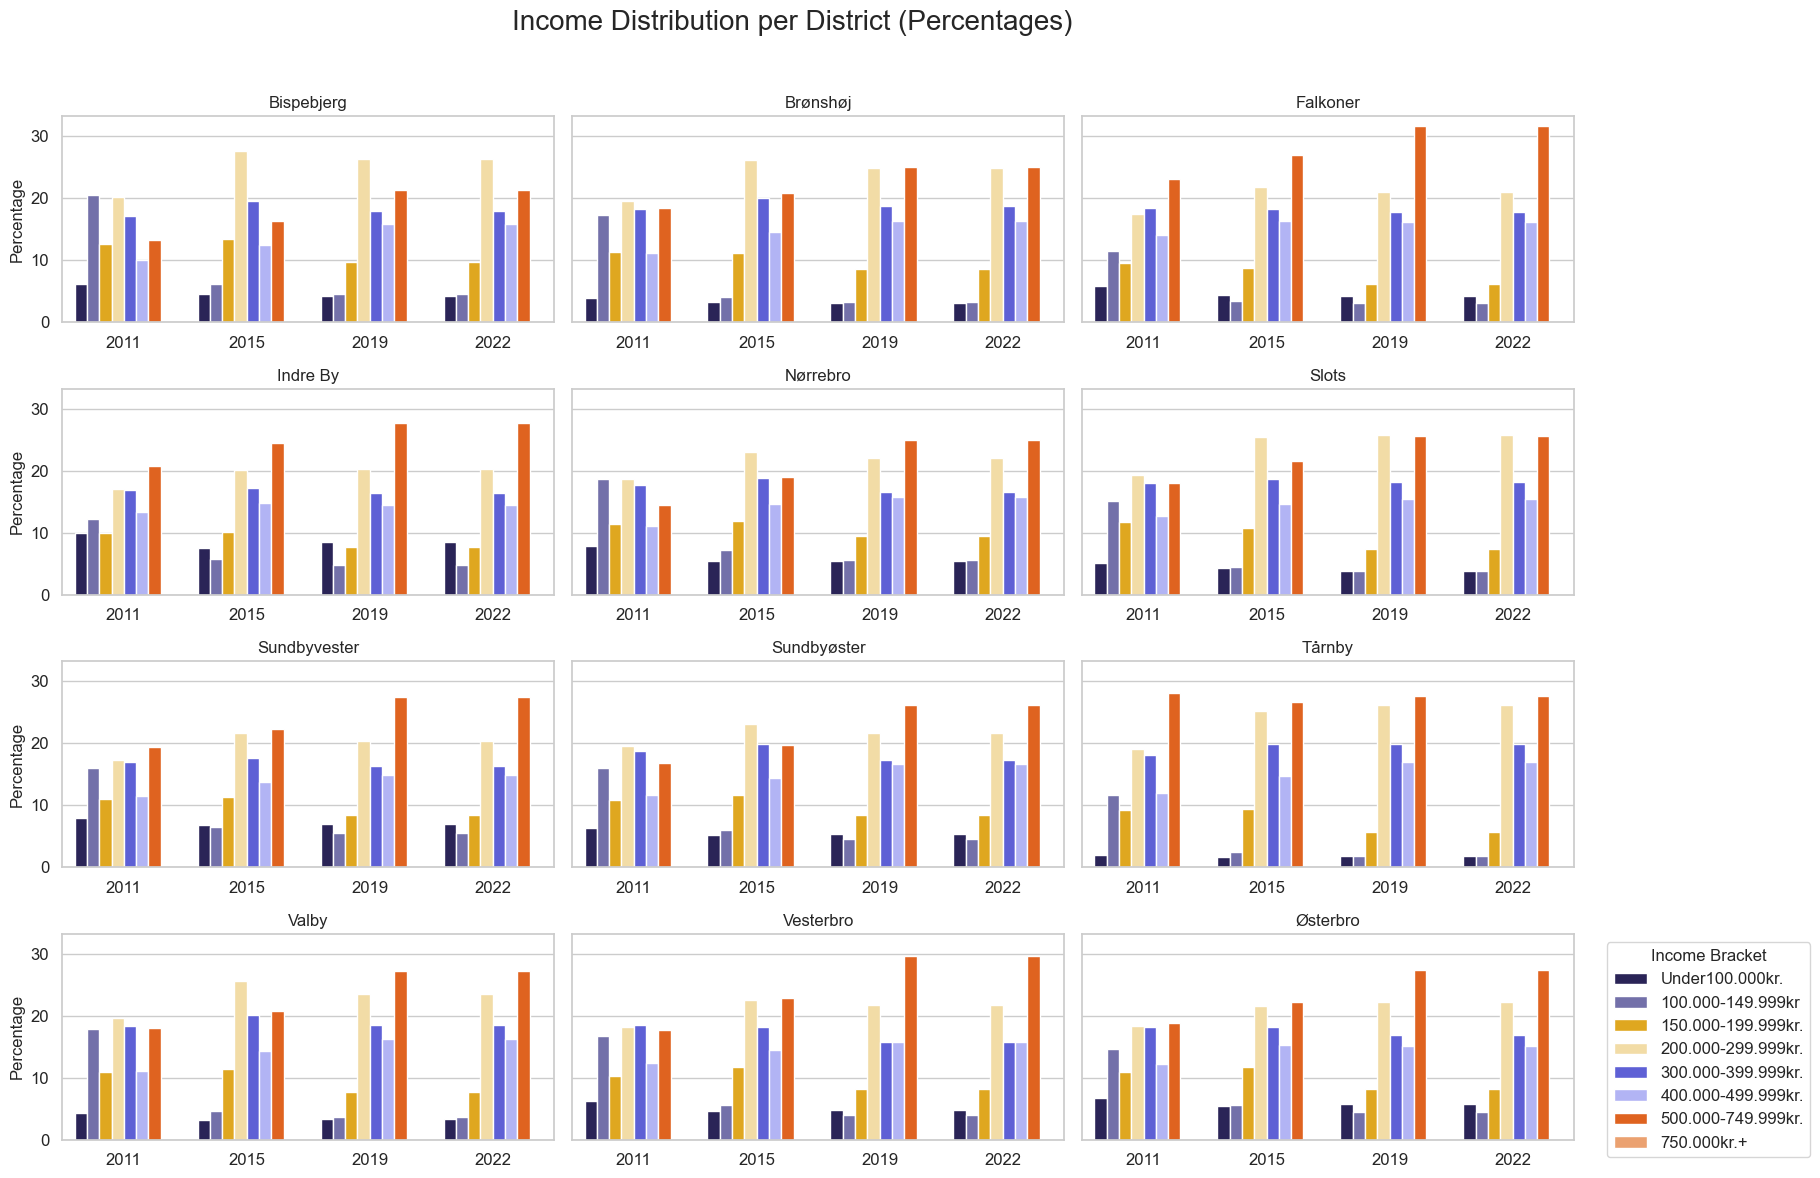

In [20]:
# Map district names
df_income_filtered['District'] = df_income_filtered['KredsNr'].map(constituency_id_to_name)

# Aggregate counts (sum) per Year, IncomeMetric, District
df_grouped = df_income_filtered.groupby(['Year', 'IncomeMetric', 'District'], observed=True)['Value'].sum().reset_index()

# Normalize to percentages within each district and year
df_grouped['Percentage'] = df_grouped.groupby(['Year', 'District'])['Value'].transform(lambda x: 100 * x / x.sum())

# Plot setup (static, seaborn)
sns.set_theme(style="whitegrid", font="Arial")

districts = df_grouped['District'].unique()
cols = 3
rows = 4
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3), sharey=True)
axes = axes.flatten()

# Apply custom colors
palette = dict(zip(income_brackets, expanded_colors[:len(income_brackets)]))

# Plot per district
for idx, district in enumerate(districts):
    ax = axes[idx]
    df_district = df_grouped[df_grouped['District'] == district]
    sns.barplot(
        data=df_district,
        x='Year',
        y='Percentage',
        hue='IncomeMetric',
        order=sorted(df_district['Year'].unique()),
        hue_order=income_brackets,
        errorbar=None,
        palette=palette,
        ax=ax
    )
    ax.set_title(district, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage', fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend_.remove()

# Remove empty subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Main title and legend
fig.suptitle('Income Distribution per District (Percentages)', fontsize=20, fontname='Arial')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.legend(title='Income Bracket', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12)
plt.show()


INFORMATIVE: Definitely differentiations between the different districts:

* Sundbyvester and Tårnby vs Sundbyøster
* Tårnby and Indre and Falkoner seems pretty alike
* Nørrebro and Bispebjerg seems similar and make the least on average

##### Housing size

Dropped due to 'Oplystareal': 0.0 (0.000%)


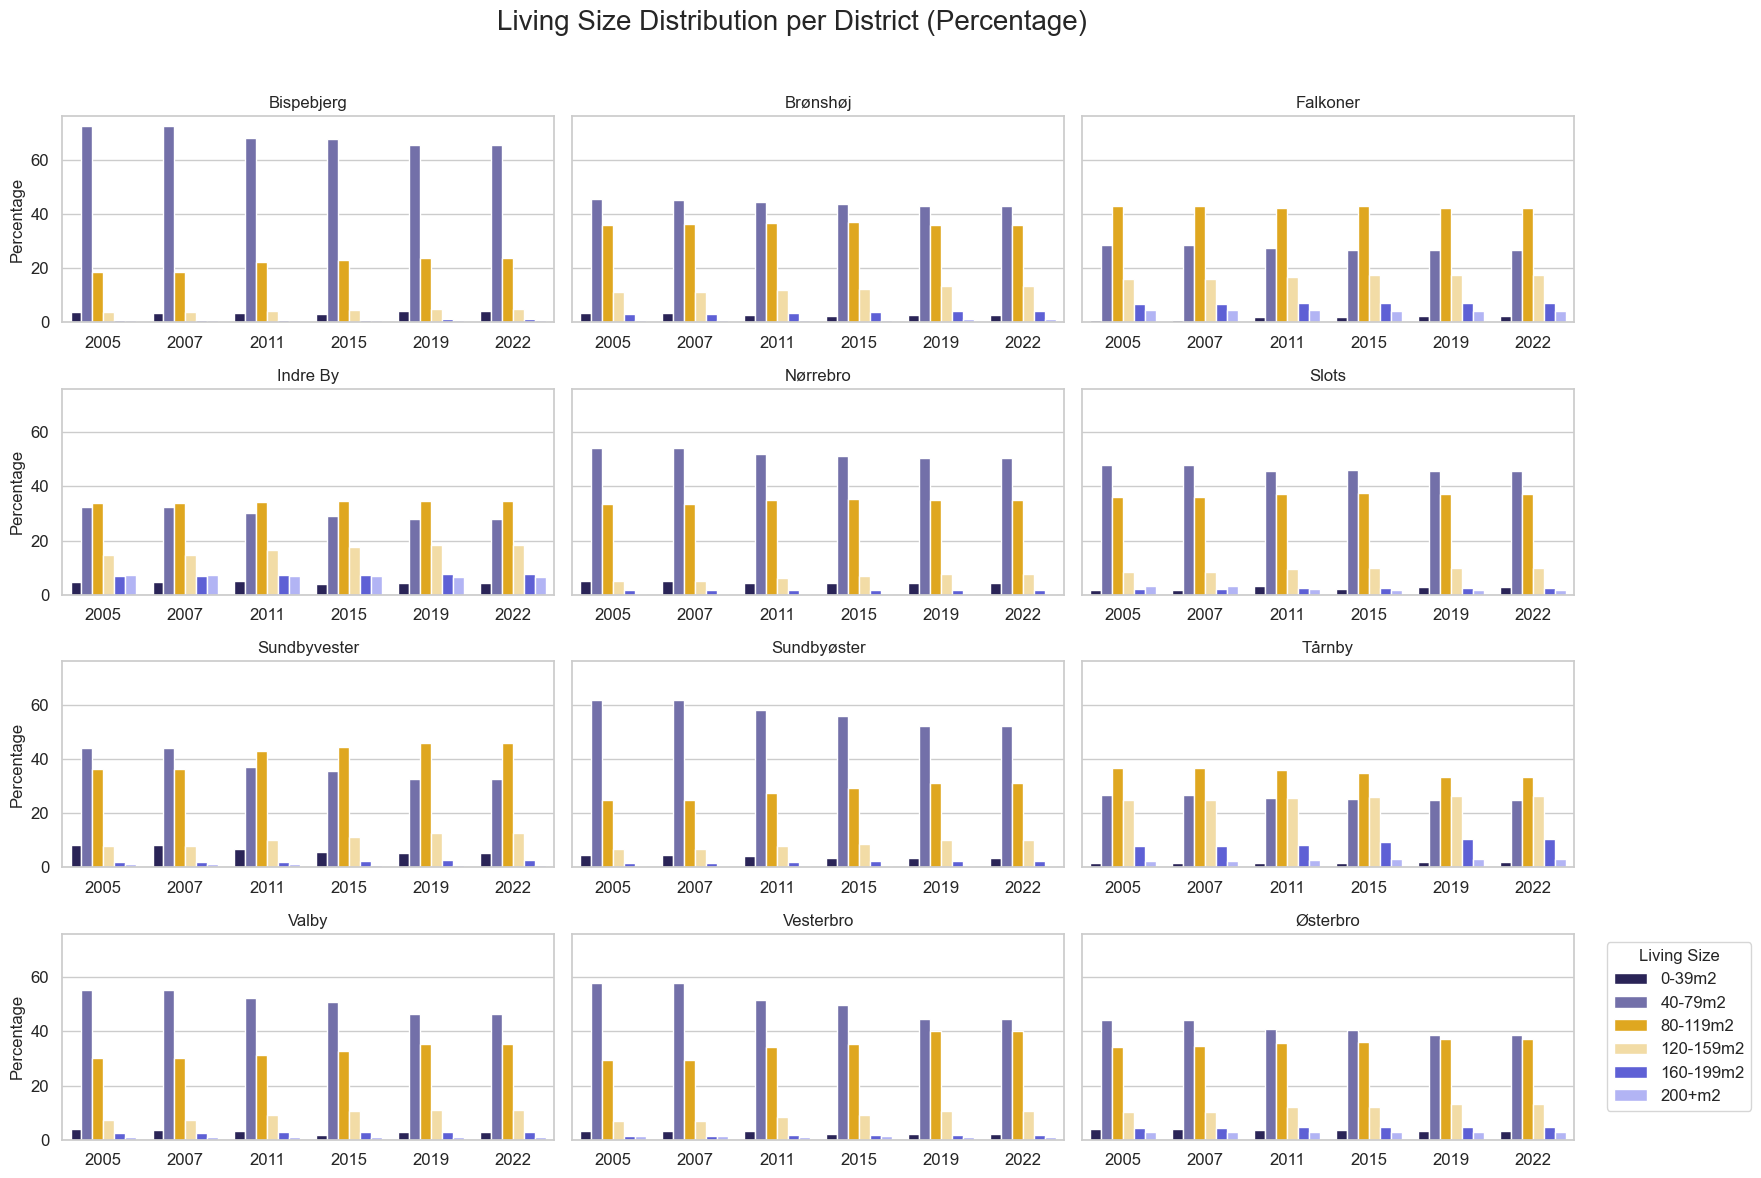

In [23]:
sns.set_theme(style="whitegrid", font="Arial")

# Drop 'Oplystareal' and report how much is dropped
dropped = df_house_size_long[df_house_size_long['HouseSize'] == 'Oplystareal']['Count'].sum()
total = df_house_size_long['Count'].sum()
print(f"Dropped due to 'Oplystareal': {dropped:,} ({dropped / total * 100:.3f}%)")

# Filter and categorize
df_filtered = df_house_size_long[df_house_size_long['HouseSize'] != 'Oplystareal'].copy()
order = ['0-39m2', '40-79m2', '80-119m2', '120-159m2', '160-199m2', '200+m2']
df_filtered['HouseSize'] = pd.Categorical(df_filtered['HouseSize'], categories=order, ordered=True)
df_filtered['District'] = df_filtered['KredsNr'].map(constituency_id_to_name)

# Group and normalize
df_grouped = df_filtered.groupby(['Year', 'HouseSize', 'District'], observed=True)['Count'].sum().reset_index()
totals = df_grouped.groupby(['Year', 'District'], observed=True)['Count'].sum().reset_index(name='Total')
df_grouped = df_grouped.merge(totals, on=['Year', 'District'])
df_grouped['Percentage'] = df_grouped['Count'] / df_grouped['Total'] * 100

# Plot
palette = dict(zip(order, expanded_colors[:len(order)]))
districts = df_grouped['District'].unique()
fig, axes = plt.subplots(4, 3, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for idx, district in enumerate(districts):
    ax = axes[idx]
    df_d = df_grouped[df_grouped['District'] == district]
    sns.barplot(
        data=df_d, x='Year', y='Percentage', hue='HouseSize',
        order=sorted(df_d['Year'].unique()), hue_order=order,
        errorbar=None, palette=palette, ax=ax
    )
    ax.set_title(district, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage', fontsize=12)
    ax.tick_params(labelsize=12)
    ax.legend_.remove()

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Living Size Distribution per District (Percentage)', fontsize=20, fontname='Arial')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.legend(title='Living Size', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12)
plt.show()


The two most common housing sizes 40-79 and 80-119 seems to either be static or increase in counts for all districts.

INFORMATIVE: There are differences in which housing size is the most common from district to district. Eg Falkoner, Indre, Slots, Sundbyvester and Tårnby has more 80-119 and Bispebjerg, Brønshøj, Nørrebro, Sundbyøster, Vesterbro, Valby and (Østerbro) has more 40-79 sized.